<a href="https://colab.research.google.com/github/iamnotrobo/data-academy/blob/main/Data_Academy_Dashboard_PLV_(Group_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi plot
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

In [2]:
# Ganti path file Excel di sini sesuai lokasi file kalian guys
EXCEL_FILE_PATH = '/content/drive/MyDrive/dataset/Data Academy Data Dashboard.xlsx'
SHEET_NAME = 'Sheet1'

def load_data_from_excel(file_path, sheet_name=0):
  """
  Load data dari excel file

  Parameternya:
  file_path (str): path file Excel nya
  sheet_name (str/int): nama sheet atau index nya

  Returnnya:
  pandas.DataFrame: Loaded dataframe
  """

  try:
    print(f"Loading data from: {file_path}")

    # Load data dari Excel
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    print(f"Successfully loaded data!")
    print(f"Data shape: {df.shape} (rows x columns)")
    print(f"Available columns: {len(df.columns)}")
    print(f"Sample columns: {list(df.columns[:10])}...") # menampilkan kolom 10 pertama

    # Menampilkan info dasar dataset
    print(f"\n Data Overview")
    print(f"  • Total Records: {len(df):,}")
    print(f"  • Total Columns: {len(df.columns)}")
    print(f"  • Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    # Check key kolom yang diperlukan untuk analisa PLV
    key_columns = ['CustomerName', 'NTF', 'AreaName', 'EffectiveRate', 'Tenor']
    missing_cols = [col for col in key_columns if col not in df.columns]
    if missing_cols:
      print(f"Missing key columns: {missing_cols}")
    else:
      print(f"All key columns found!")

    return df

  except FileNotFoundError:
    print(f"File not found: {file_path}")
    print(f"Please make sure the file exists and the path is correct.")
    print(f"Current working directory files ending with .xlsx:")
    xlsx_files = [f for f in os.listdir('.') if f.endswith('.xlsx')]
    for f in xlsx_files:
      print(f"  • {f}")
    return None

  except Exception as e:
    print(f"Error loading file: {e}")
    print(f"Please check:")
    print(f"  • File path is correct")
    print(f"  • File is not corrupted")
    print(f"  • File is npt password protected")
    print(f"  • Sheet name/index is correct")
    return None

def clean_and_prepare_data(df):
  """
  Bersihkan dan siapkan data untuk analisa PLV

  Parameternya:
  df (pandas.Dataframe): Dataframe mentah dari Excel

  Returnnya:
  pandas.Dataframe: Dataframe yang dibersihkan
  """

  print("Cleaning and preparing data...")

  # Buat copy untuk menghindari modifikasi data original
  df_clean = df.copy()

  # Bersihkan nama kolom (hilangkan spasi dan karakter spesial)
  df_clean.columns = df_clean.columns.str.strip()

  # Konversi kolom numerik
  numeric_columns = ['NTF', 'TotalOTR', 'Tenor', 'EffectiveRate', 'InstallmentAmount']
  for col in numeric_columns:
    if col in df_clean.columns:
      # Hilangkan non-numerik karakter lalu konversi
      df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')

  # Konversi kolom tanggal
  date_columns = ['DateEntryApplicationData', 'ApproveDate', 'GoliveDate']
  for col in date_columns:
    if col in df_clean.columns:
      df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

  # Konversi kolom text
  text_columns = ['CustomerName', 'AreaName', 'BranchName', 'SalesName', 'SEGMENT TYPE_MIS', 'Risk_Score_Desc']
  for col in text_columns:
    if col in df_clean.columns:
      df_clean[col] = df_clean[col].astype(str).str.strip().str.upper()

  # Menangani missing value
  print(f"Checking for missing values...")
  missing_data = df_clean.isnull().sum()
  if missing_data.sum() > 0:
    print(f"  • Found {missing_data.sum()} missing values")
    # Isi kolom numerik dengan median
    for col in numeric_columns:
      if col in df_clean.columns and df_clean[col].isnull().sum() > 0: # Added () to call .sum()
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
  else:
    print(f"  • No missing values found!")

  # Hilangkan rows dimana semua key kolom null
  key_cols = ['CustomerName', 'NTF']
  df_clean = df_clean.dropna(subset=[col for col in key_cols if col in df_clean.columns], how='all')

  print(f"Data cleaning completed!")
  print(f"Final dataset: {df_clean.shape[0]} rows x {df_clean.shape[1]} columns") # Corrected df.clean to df_clean

  return df_clean

def calculate_plv_metrics(df):
    """
    Menghitung metriks PLV untuk Dataframe

    Parameter:
    df (pandas.Dataframe): Input Dataframe

    Returnnya:
    pandas.Dataframe: Dataframe dengan metriks PLV
    """

    print("Calculating PLV metrics...")

    # Hitung Recency (hari sejak aplikasi terakhir)
    if 'DataEntryApplicationData' in df.columns and not df['DataEntryApplicationData'].isnull().all():
        current_date = datetime.now()
        df['Recency_Days'] = (current_date - df['DataEntryApplicationData']).dt.days
        df['Recency_Days'] = df['Recency_Days'].abs() # memastikan values positif
    else:
        # Simulasi recency berdasarkan data yang tersedia
        print(" • DateEntryApplicationData not found or all null, simulating recency...")
        np.random.seed(42)
        df['Recency_Days'] = np.random.randint(1, 365, len(df))

    # Hitung Frequency (simulasi jika tidak tersedia)
    if 'Frequency' not in df.columns:
        print(" • Frequency not found, simulating based on customer patterns...")
        # Simulasi frequency berdasarkan pola nama customer
        np.random.seed(42)
        df['Frequency'] = np.random.randint(1, 6, len(df))

        # Customer dengan NTF lebih tinggi cenderung memiliki frekuensi lebih tinggi
        if 'NTF' in df.columns and not df['NTF'].isnull().all():
            try:
                ntf_quantiles = df['NTF'].quantile([0.2, 0.4, 0.6, 0.8]).dropna()
                if len(ntf_quantiles) == 4: # Check if all quartiles were calculated
                    df.loc[df['NTF'] > ntf_quantiles[0.8], 'Frequency'] += 2
                    df.loc[df['NTF'] > ntf_quantiles[0.6], 'Frequency'] += 1
            except ValueError:
                print("    • Could not use NTF quantiles for frequency simulation.")


    # Hitung Monetary (estimasi profit dari loan)
    if all(col in df.columns and not df[col].isnull().all() for col in ['NTF', 'EffectiveRate', 'Tenor']):
        print("   • Calculating monetary value from NTF, EffectiveRate, and Tenor...")
        df['Monetary'] = df['NTF'] * (df['EffectiveRate'] / 100) * (df['Tenor'] / 12)
    elif 'NTF' in df.columns and not df['NTF'].isnull().all():
        print("   • Using NTF as monetary value...")
        df['Monetary'] = df['NTF']
    else:
        print("   • No Monetary columns found or all null, using default values...")
        df['Monetary'] = 1000000 # default value (satu juta)

    # Memastikan tidak ada negatif atau nol values
    df['Recency_Days'] = df['Recency_Days'].clip(lower=1)
    df['Frequency'] = df['Frequency'].clip(lower=1)
    df['Monetary'] = df['Monetary'].clip(lower=1000)

    # Buat skor RFM (skala 1-5), handle cases with insufficient unique values
    print("   • Creating RFM Scores...")
    for col, asc in [('Recency_Days', False), ('Frequency', True), ('Monetary', True)]:
        score_col = col[0] + '_Score'
        try:
            # Attempt to use qcut (quantiles)
            df[score_col] = pd.qcut(df[col].rank(method='first'), 5, labels=False, duplicates='drop') + 1
            if not asc: # Reverse score for Recency
                 df[score_col] = 6 - df[score_col]
        except ValueError:
            # If qcut fails (e.g., not enough unique values), use cut (equal-width bins)
            print(f"    • Could not create 5 bins for {col} using qcut. Using cut instead.")
            try:
                num_bins = min(5, df[col].nunique()) # Use at most 5 bins, or fewer if less unique values
                df[score_col] = pd.cut(df[col].rank(method='first'), num_bins, labels=False, include_lowest=True) + 1
                if not asc: # Reverse score for Recency
                     df[score_col] = num_bins + 1 - df[score_col]
            except ValueError:
                # If cut also fails, assign a default score
                print(f"    • Could not create bins for {col} using cut. Assigning default score of 3.")
                df[score_col] = 3

        # Ensure scores are numeric and handle potential NaNs from cut/qcut
        df[score_col] = pd.to_numeric(df[score_col], errors='coerce').fillna(3)


    # Hitung PLV skor (Bobot: Recency 20%, Frequency 30%, Monetary 50%)
    df['PLV_Score'] = (df['R_Score'] * 0.2 + df['F_Score'] * 0.3 + df['M_Score'] * 0.5)

    # Buat segmen PLV
    df['PLV_Segment'] = pd.cut(df['PLV_Score'],
                              bins=[0, 2, 3, 4, 5],
                              labels=['Low Value', 'Medium Value', 'High Value', 'VIP'],
                              include_lowest=True)

    print("✅ PLV Metrics calculated successfully!")
    print(f"   • Average PLV Score: {df['PLV_Score'].mean():.2f}")
    print(f"   • PLV Segments distribution:")
    segment_counts = df['PLV_Segment'].value_counts()
    for segment, count in segment_counts.items():
        print(f"     - {segment}: {count} customers ({count/len(df)*100:.1f}%)")

    return df

def create_plv_dashboard(df):
    """
    Buat dashboard PLV yang luas

    Parameters:
    df (pandas.DataFrame): Dataframe with PLV metrics
    """

    print("\n📈 Creating PLV Dashboard...")

    # Membuat figur utama
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Partner Lifetime Value (PLV) Analysis Dashboard',
                fontsize=24, fontweight='bold', y=0.98)

    # Menentukan palet warna (color palette)
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592941', '#0F4C75']

    # Layout: 3 rows, 4 columns
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    # 1. KEY METRICS (Top Row)
    # Total Customers
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.text(0.5, 0.5, f"{len(df):,}", ha='center', va='center', fontsize=28, fontweight='bold')
    ax1.text(0.5, 0.2, "Total Customers", ha='center', va='center', fontsize=12)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_title("👥 Customers", fontsize=14, fontweight='bold')
    ax1.axis('off')
    ax1.patch.set_facecolor(colors[0])
    ax1.patch.set_alpha(0.1)

    # Total NTF
    ax2 = fig.add_subplot(gs[0, 1])
    total_ntf = df['NTF'].sum() / 1e9 if 'NTF' in df.columns else 0
    ax2.text(0.5, 0.5, f"{total_ntf:.1f}B", ha='center', va='center', fontsize=28, fontweight='bold')
    ax2.text(0.5, 0.2, "Total NTF", ha='center', va='center', fontsize=12)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_title("💰 NTF", fontsize=14, fontweight='bold')
    ax2.axis('off')
    ax2.patch.set_facecolor(colors[1])
    ax2.patch.set_alpha(0.1)

    # Average PLV Score
    ax3 = fig.add_subplot(gs[0, 2])
    avg_plv = df['PLV_Score'].mean()
    ax3.text(0.5, 0.5, f"{avg_plv:.2f}", ha='center', va='center', fontsize=28, fontweight='bold')
    ax3.text(0.5, 0.2, "Avg PLV Score", ha='center', va='center', fontsize=12)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.set_title("⭐ PLV Score", fontsize=14, fontweight='bold')
    ax3.axis('off')
    ax3.patch.set_facecolor(colors[2])
    ax3.patch.set_alpha(0.1)

    # Approval Rate
    ax4 = fig.add_subplot(gs[0, 3])
    if 'ApplicationStatus' in df.columns:
        approval_rate = (df['ApplicationStatus'].str.upper() == 'APPROVED').mean() * 100
    else:
        approval_rate = 85  # Default assumption
    ax4.text(0.5, 0.5, f"{approval_rate:.1f}%", ha='center', va='center', fontsize=28, fontweight='bold')
    ax4.text(0.5, 0.2, "Approval Rate", ha='center', va='center', fontsize=12)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.set_title("✅ Approval", fontsize=14, fontweight='bold')
    ax4.axis('off')
    ax4.patch.set_facecolor(colors[3])
    ax4.patch.set_alpha(0.1)

    # 2. PLV SEGMENT DISTRIBUTION
    ax5 = fig.add_subplot(gs[1, 0])
    plv_counts = df['PLV_Segment'].value_counts()
    wedges, texts, autotexts = ax5.pie(plv_counts.values, labels=plv_counts.index,
                                      autopct='%1.1f%%', colors=colors[:len(plv_counts)])
    ax5.set_title('PLV Segment Distribution', fontsize=14, fontweight='bold')

    # 3. NTF BY AREA
    ax6 = fig.add_subplot(gs[1, 1])
    if 'AreaName' in df.columns and 'NTF' in df.columns:
        area_ntf = df.groupby('AreaName')['NTF'].sum().sort_values(ascending=True) / 1e6
        bars = ax6.barh(range(len(area_ntf)), area_ntf.values, color=colors[0])
        ax6.set_yticks(range(len(area_ntf)))
        ax6.set_yticklabels(area_ntf.index)
        ax6.set_xlabel('NTF (Millions)')
        ax6.set_title('NTF by Area', fontsize=14, fontweight='bold')
        ax6.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax6.text(width + max(area_ntf.values) * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.0f}M', ha='left', va='center', fontsize=9)
    else:
        ax6.text(0.5, 0.5, 'Area/NTF data\nnot available', ha='center', va='center', fontsize=12)
        ax6.set_xlim(0, 1)
        ax6.set_ylim(0, 1)
        ax6.axis('off')

    # 4. PLV SCORE BY SEGMENT TYPE
    ax7 = fig.add_subplot(gs[1, 2])
    segment_col = 'SEGMENT_TYPE' if 'SEGMENT_TYPE' in df.columns else 'SEGMENT TYPE_MIS'

    if segment_col in df.columns:
        segment_plv = df.groupby(segment_col)['PLV_Score'].mean().sort_values(ascending=True)
        bars = ax7.barh(range(len(segment_plv)), segment_plv.values, color=colors[1])
        ax7.set_yticks(range(len(segment_plv)))
        ax7.set_yticklabels([label[:15] + '...' if len(label) > 15 else label for label in segment_plv.index])
        ax7.set_xlabel('PLV Score')
        ax7.set_title('Avg PLV Score by Segment', fontsize=14, fontweight='bold')
        ax7.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax7.text(width + 0.05, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}', ha='left', va='center', fontsize=9)
    else:
        ax7.text(0.5, 0.5, 'Segment data\nnot available', ha='center', va='center', fontsize=12)
        ax7.set_xlim(0, 1)
        ax7.set_ylim(0, 1)
        ax7.axis('off')

    # 5. RISK DISTRIBUTION
    ax8 = fig.add_subplot(gs[1, 3])
    if 'Risk_Score_Desc' in df.columns:
        risk_counts = df['Risk_Score_Desc'].value_counts()
        bars = ax8.bar(range(len(risk_counts)), risk_counts.values, color=colors[2])
        ax8.set_xticks(range(len(risk_counts)))
        ax8.set_xticklabels([label.replace(' ', '\n') for label in risk_counts.index], fontsize=9)
        ax8.set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
        ax8.set_ylabel('Count')
        ax8.grid(axis='y', alpha=0.3)

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2, height + max(risk_counts.values) * 0.01,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    else:
        ax8.text(0.5, 0.5, 'Risk data\nnot available', ha='center', va='center', fontsize=12)
        ax8.set_xlim(0, 1)
        ax8.set_ylim(0, 1)
        ax8.axis('off')

    # 6. CORRELATION HEATMAP
    ax9 = fig.add_subplot(gs[2, :2])
    # Select numeric columns for correlation
    numeric_cols = ['NTF', 'TotalOTR', 'Tenor', 'EffectiveRate', 'InstallmentAmount',
                    'Recency_Days', 'Frequency', 'Monetary', 'PLV_Score']
    available_cols = [col for col in numeric_cols if col in df.columns]

    if len(available_cols) >= 3:
        corr_matrix = df[available_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                    square=True, ax=ax9, cbar_kws={"shrink": .8}, fmt='.2f')
        ax9.set_title('Correlation Matrix', fontsize=14, fontweight='bold')
    else:
        ax9.text(0.5, 0.5, 'Insufficient numeric\ncolumns for correlation', ha='center', va='center', fontsize=12)
        ax9.set_xlim(0, 1)
        ax9.set_ylim(0, 1)
        ax9.axis('off')

    # 7. TOP CUSTOMERS TABLE
    ax10 = fig.add_subplot(gs[2, 2:])
    ax10.axis('off')

    # Get top customers by PLV Score
    top_n = min(8, len(df))
    customer_col = 'CustomerName' if 'CustomerName' in df.columns else df.columns[0]
    area_col = 'AreaName' if 'AreaName' in df.columns else 'N/A'
    risk_col = 'Risk_Score_Desc' if 'Risk_Score_Desc' in df.columns else 'N/A'

    top_customers = df.nlargest(top_n, 'PLV_Score').copy()

    # Prepare table data
    table_data = []
    for idx, row in top_customers.iterrows():
        customer_name = str(row[customer_col])[:15] + '...' if len(str(row[customer_col])) > 15 else str(row[customer_col])
        area_name = str(row[area_col]) if area_col != 'N/A' else 'N/A'
        risk_desc = str(row[risk_col]) if risk_col != 'N/A' else 'N/A'
        ntf_value = f"{row['NTF']/1e6:.1f}M" if 'NTF' in df.columns else 'N/A'

        table_data.append([
            customer_name,
            area_name[:10],
            f"{row['PLV_Score']:.2f}",
            str(row['PLV_Segment']),
            ntf_value,
            risk_desc[:10]
        ])

    # Create table
    table = ax10.table(cellText=table_data,
                      colLabels=['Customer', 'Area', 'PLV Score', 'Segment', 'NTF', 'Risk'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)

    # Style the table
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor(colors[0])
            cell.set_text_props(color='white')
        else:
            cell.set_facecolor('#f8f9fa')
            if j == 3:  # PLV Segment column
                segment = cell.get_text().get_text()
                if 'VIP' in segment:
                    cell.set_facecolor('#FFD700')
                elif 'High Value' in segment:
                    cell.set_facecolor('#FFA500')

    ax10.set_title(f'Top {top_n} Customers by PLV Score', fontsize=14, fontweight='bold', y=0.95)

    plt.tight_layout()
    plt.show()

    print("✅ Dashboard created successfully!")

def generate_summary_report(df):
    """
    Generate laporan detail rangkuman analisa PLV

    Parameters:
    df (pandas.DataFrame): Dataframe with PLV metrics
    """

    print("\n" + "="*60)
    print("📊 DETAILED PLV ANALYSIS REPORT")
    print("="*60)

    # Overall Statistics
    print(f"\n1. OVERALL STATISTICS:")
    print(f"   • Total Customers: {len(df):,}")
    if 'NTF' in df.columns:
        print(f"   • Total NTF: Rp {df['NTF'].sum():,.0f}")
        print(f"   • Average NTF: Rp {df['NTF'].mean():,.0f}")
    print(f"   • Average PLV Score: {df['PLV_Score'].mean():.2f}")
    print(f"   • PLV Score Range: {df['PLV_Score'].min():.2f} - {df['PLV_Score'].max():.2f}")

    # PLV Segment Analysis
    print(f"\n2. PLV SEGMENT ANALYSIS:")
    segment_summary = df.groupby('PLV_Segment').agg({
        'CustomerName' if 'CustomerName' in df.columns else df.columns[0]: 'count',
        'NTF' if 'NTF' in df.columns else 'PLV_Score': ['sum', 'mean'],
        'PLV_Score': 'mean'
    }).round(2)

    if 'NTF' in df.columns:
        segment_summary.columns = ['Count', 'Total_NTF', 'Avg_NTF', 'Avg_PLV']
        segment_summary['Total_NTF'] = segment_summary['Total_NTF'] / 1e6
        segment_summary['Avg_NTF'] = segment_summary['Avg_NTF'] / 1e6
        segment_summary['Share_%'] = (segment_summary['Count'] / len(df) * 100).round(1)
    else:
        segment_summary.columns = ['Count', 'Total_Score', 'Avg_Score', 'Avg_PLV']
        segment_summary['Share_%'] = (segment_summary['Count'] / len(df) * 100).round(1)

    print(segment_summary)

    # Area Performance (jika tersedia)
    if 'AreaName' in df.columns:
        print(f"\n3. AREA PERFORMANCE:")
        area_summary = df.groupby('AreaName').agg({
            'CustomerName' if 'CustomerName' in df.columns else df.columns[0]: 'count',
            'NTF' if 'NTF' in df.columns else 'PLV_Score': 'sum',
            'PLV_Score': 'mean'
        }).round(2)

        if 'NTF' in df.columns:
            area_summary.columns = ['Customers', 'Total_NTF_M', 'Avg_PLV']
            area_summary['Total_NTF_M'] = area_summary['Total_NTF_M'] / 1e6
        else:
            area_summary.columns = ['Customers', 'Total_Score', 'Avg_PLV']

        print(area_summary.sort_values('Avg_PLV', ascending=False))

    # Channel Analysis (jika tersedia)
    if 'Channel' in df.columns:
        print(f"\n4. CHANNEL PERFORMANCE:")
        channel_summary = df.groupby('Channel').agg({
            'CustomerName' if 'CustomerName' in df.columns else df.columns[0]: 'count',
            'NTF' if 'NTF' in df.columns else 'PLV_Score': 'sum',
            'PLV_Score': 'mean'
        }).round(2)

        if 'NTF' in df.columns:
            channel_summary.columns = ['Customers', 'Total_NTF_M', 'Avg_PLV']
            channel_summary['Total_NTF_M'] = channel_summary['Total_NTF_M'] / 1e6
        else:
            channel_summary.columns = ['Customers', 'Total_Score', 'Avg_PLV']

        print(channel_summary.sort_values('Avg_PLV', ascending=False))

    # Rekomendasi Strategi
    print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
    print("="*40)

    recommendations = [
        "1. 🏆 VIP CUSTOMERS: Focus retention campaigns on VIP segment customers",
        "2. 📈 GROWTH OPPORTUNITY: Develop targeted offers for Medium Value customers",
        "3. 🔄 CROSS-SELLING: Implement cross-selling for high frequency customers",
        "4. ⚠️  RISK MONITORING: Monitor high-risk customers with high PLV scores",
        "5. 🎪 LOYALTY PROGRAMS: Create loyalty programs for repeat customers",
        "6. 📊 REGULAR REVIEW: Recalculate PLV scores monthly/quarterly",
        "7. 🤝 PARTNERSHIP: Strengthen relationships with top-performing areas/channels",
        "8. 🎯 SEGMENTATION: Use PLV segments for personalized marketing campaigns"
    ]

    for rec in recommendations:
        print(rec)

    print(f"\n✅ Analysis completed successfully!")

In [3]:
def main():
    """
    Main function untuk menjalankan analisa PLV
    """

    print("🚀 Starting Partner Lifetime Value (PLV) Analysis...")
    print("="*60)

    # Step 1: Load data dari Excel
    df_raw = load_data_from_excel(EXCEL_FILE_PATH, SHEET_NAME)

    if df_raw is None:
        print("❌ Cannot proceed without data. Please check the file path and try again.")
        return None

    # Step 2: Bersihkan dan Siapkan data
    df_clean = clean_and_prepare_data(df_raw)

    # Step 3: Hitung PLV Metriks
    df_with_plv = calculate_plv_metrics(df_clean)

    # Step 4: Membuat Dashboard
    create_plv_dashboard(df_with_plv)

    # Step 5: Generate laporan rangkuman
    generate_summary_report(df_with_plv)

    # Step 6: Simpan hasil (opsional)
    try:
        output_filename = f"PLV_Analysis_Results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

        # Create multiple sheets
        with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
            # Main data with PLV scores
            df_with_plv.to_excel(writer, sheet_name='PLV_Analysis', index=False)

            # Summary by segment
            segment_summary = df_with_plv.groupby('PLV_Segment').agg({
                'CustomerName' if 'CustomerName' in df_with_plv.columns else df_with_plv.columns[0]: 'count',
                'NTF' if 'NTF' in df_with_plv.columns else 'PLV_Score': ['sum', 'mean'],
                'PLV_Score': 'mean',
                'Monetary': 'sum'
            }).round(2)
            segment_summary.to_excel(writer, sheet_name='Segment_Summary')

            # Top customers
            top_customers = df_with_plv.nlargest(50, 'PLV_Score')
            top_customers.to_excel(writer, sheet_name='Top_Customers', index=False)

            # Area summary (if available)
            if 'AreaName' in df_with_plv.columns:
                area_summary = df_with_plv.groupby('AreaName').agg({
                    'CustomerName' if 'CustomerName' in df_with_plv.columns else df_with_plv.columns[0]: 'count',
                    'NTF' if 'NTF' in df_with_plv.columns else 'PLV_Score': 'sum',
                    'PLV_Score': 'mean'
                }).round(2)
                area_summary.to_excel(writer, sheet_name='Area_Summary')

        print(f"\n💾 Results saved to: {output_filename}")

    except Exception as e:
        print(f"\n⚠️  Could not save results to Excel: {e}")
        print("💡 Results are still available in the dataframe for further analysis")

    print(f"\n🎉 PLV Analysis completed successfully!")
    print(f"📊 Final dataset contains {len(df_with_plv)} records with PLV scores")

    return df_with_plv

In [ ]:
# ==========================================
# ADDITIONAL UTILITY FUNCTIONS
# ==========================================

def quick_analysis(file_path, sheet_name=0):
    """
    Quick PLV analysis without detailed dashboard

    Parameters:
    file_path (str): Path to Excel file
    sheet_name (str/int): Sheet name or index

    Returns:
    pandas.DataFrame: DataFrame with PLV scores
    """

    # Temporarily update file path
    global EXCEL_FILE_PATH, SHEET_NAME
    original_path = EXCEL_FILE_PATH
    original_sheet = SHEET_NAME

    EXCEL_FILE_PATH = file_path
    SHEET_NAME = sheet_name

    try:
        print("⚡ Running Quick PLV Analysis...")

        # Load and process data
        df_raw = load_data_from_excel(file_path, sheet_name)
        if df_raw is None:
            return None

        df_clean = clean_and_prepare_data(df_raw)
        df_with_plv = calculate_plv_metrics(df_clean)

        # Show quick summary
        print(f"\n📊 QUICK SUMMARY:")
        print(f"   • Total Customers: {len(df_with_plv):,}")
        print(f"   • Average PLV Score: {df_with_plv['PLV_Score'].mean():.2f}")
        print(f"   • VIP Customers: {(df_with_plv['PLV_Segment'] == 'VIP').sum()}")
        print(f"   • High Value Customers: {(df_with_plv['PLV_Segment'] == 'High Value').sum()}")

        return df_with_plv

    finally:
        # Restore original settings
        EXCEL_FILE_PATH = original_path
        SHEET_NAME = original_sheet

def export_plv_segments(df, filename=None):
    """
    Export PLV segments to separate Excel sheets

    Parameters:
    df (pandas.DataFrame): DataFrame with PLV scores
    filename (str): Output filename (optional)
    """

    if filename is None:
        filename = f"PLV_Segments_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # Export each segment to separate sheet
            for segment in df['PLV_Segment'].unique():
                if pd.notna(segment):  # Skip NaN segments
                    segment_data = df[df['PLV_Segment'] == segment]
                    sheet_name = str(segment).replace(' ', '_')
                    segment_data.to_excel(writer, sheet_name=sheet_name, index=False)

        print(f"✅ PLV segments exported to: {filename}")

    except Exception as e:
        print(f"❌ Error exporting segments: {e}")

def compare_periods(file_path1, file_path2, sheet_name=0):
    """
    Compare PLV metrics between two time periods

    Parameters:
    file_path1 (str): Path to first period Excel file
    file_path2 (str): Path to second period Excel file
    sheet_name (str/int): Sheet name or index
    """

    print("📊 Comparing PLV metrics between periods...")

    # Load both datasets
    df1 = quick_analysis(file_path1, sheet_name)
    df2 = quick_analysis(file_path2, sheet_name)

    if df1 is None or df2 is None:
        print("❌ Cannot compare - one or both files could not be loaded")
        return

    # Compare key metrics
    print(f"\n📈 PERIOD COMPARISON:")
    print(f"{'Metric':<25} {'Period 1':<15} {'Period 2':<15} {'Change':<15}")
    print("-" * 70)

    metrics = [
        ('Total Customers', len(df1), len(df2)),
        ('Avg PLV Score', df1['PLV_Score'].mean(), df2['PLV_Score'].mean()),
        ('VIP Customers', (df1['PLV_Segment'] == 'VIP').sum(), (df2['PLV_Segment'] == 'VIP').sum()),
        ('High Value Customers', (df1['PLV_Segment'] == 'High Value').sum(), (df2['PLV_Segment'] == 'High Value').sum())
    ]

    if 'NTF' in df1.columns and 'NTF' in df2.columns:
        metrics.append(('Total NTF (B)', df1['NTF'].sum()/1e9, df2['NTF'].sum()/1e9))

    for metric_name, val1, val2 in metrics:
        change = val2 - val1
        change_pct = (change / val1 * 100) if val1 != 0 else 0
        print(f"{metric_name:<25} {val1:<15.2f} {val2:<15.2f} {change:+.2f} ({change_pct:+.1f}%)")

🚀 Starting Partner Lifetime Value (PLV) Analysis...
Loading data from: /content/drive/MyDrive/dataset/Data Academy Data Dashboard.xlsx
Successfully loaded data!
Data shape: (12469, 95) (rows x columns)
Available columns: 95
Sample columns: ['AreaName', 'BranchName', 'SalesName', 'NTF', 'GoliveDate', 'Tenor', 'SupplierId', 'SupplierName', 'ProductName', 'ProspectID']...

 Data Overview
  • Total Records: 12,469
  • Total Columns: 95
  • Memory Usage: 28.2 MB
All key columns found!
Cleaning and preparing data...
Checking for missing values...
  • Found 969383 missing values
Data cleaning completed!
Final dataset: 12469 rows x 95 columns
Calculating PLV metrics...
 • DateEntryApplicationData not found or all null, simulating recency...
 • Frequency not found, simulating based on customer patterns...
   • Calculating monetary value from NTF, EffectiveRate, and Tenor...
   • Creating RFM Scores...
✅ PLV Metrics calculated successfully!
   • Average PLV Score: 3.00
   • PLV Segments distribu

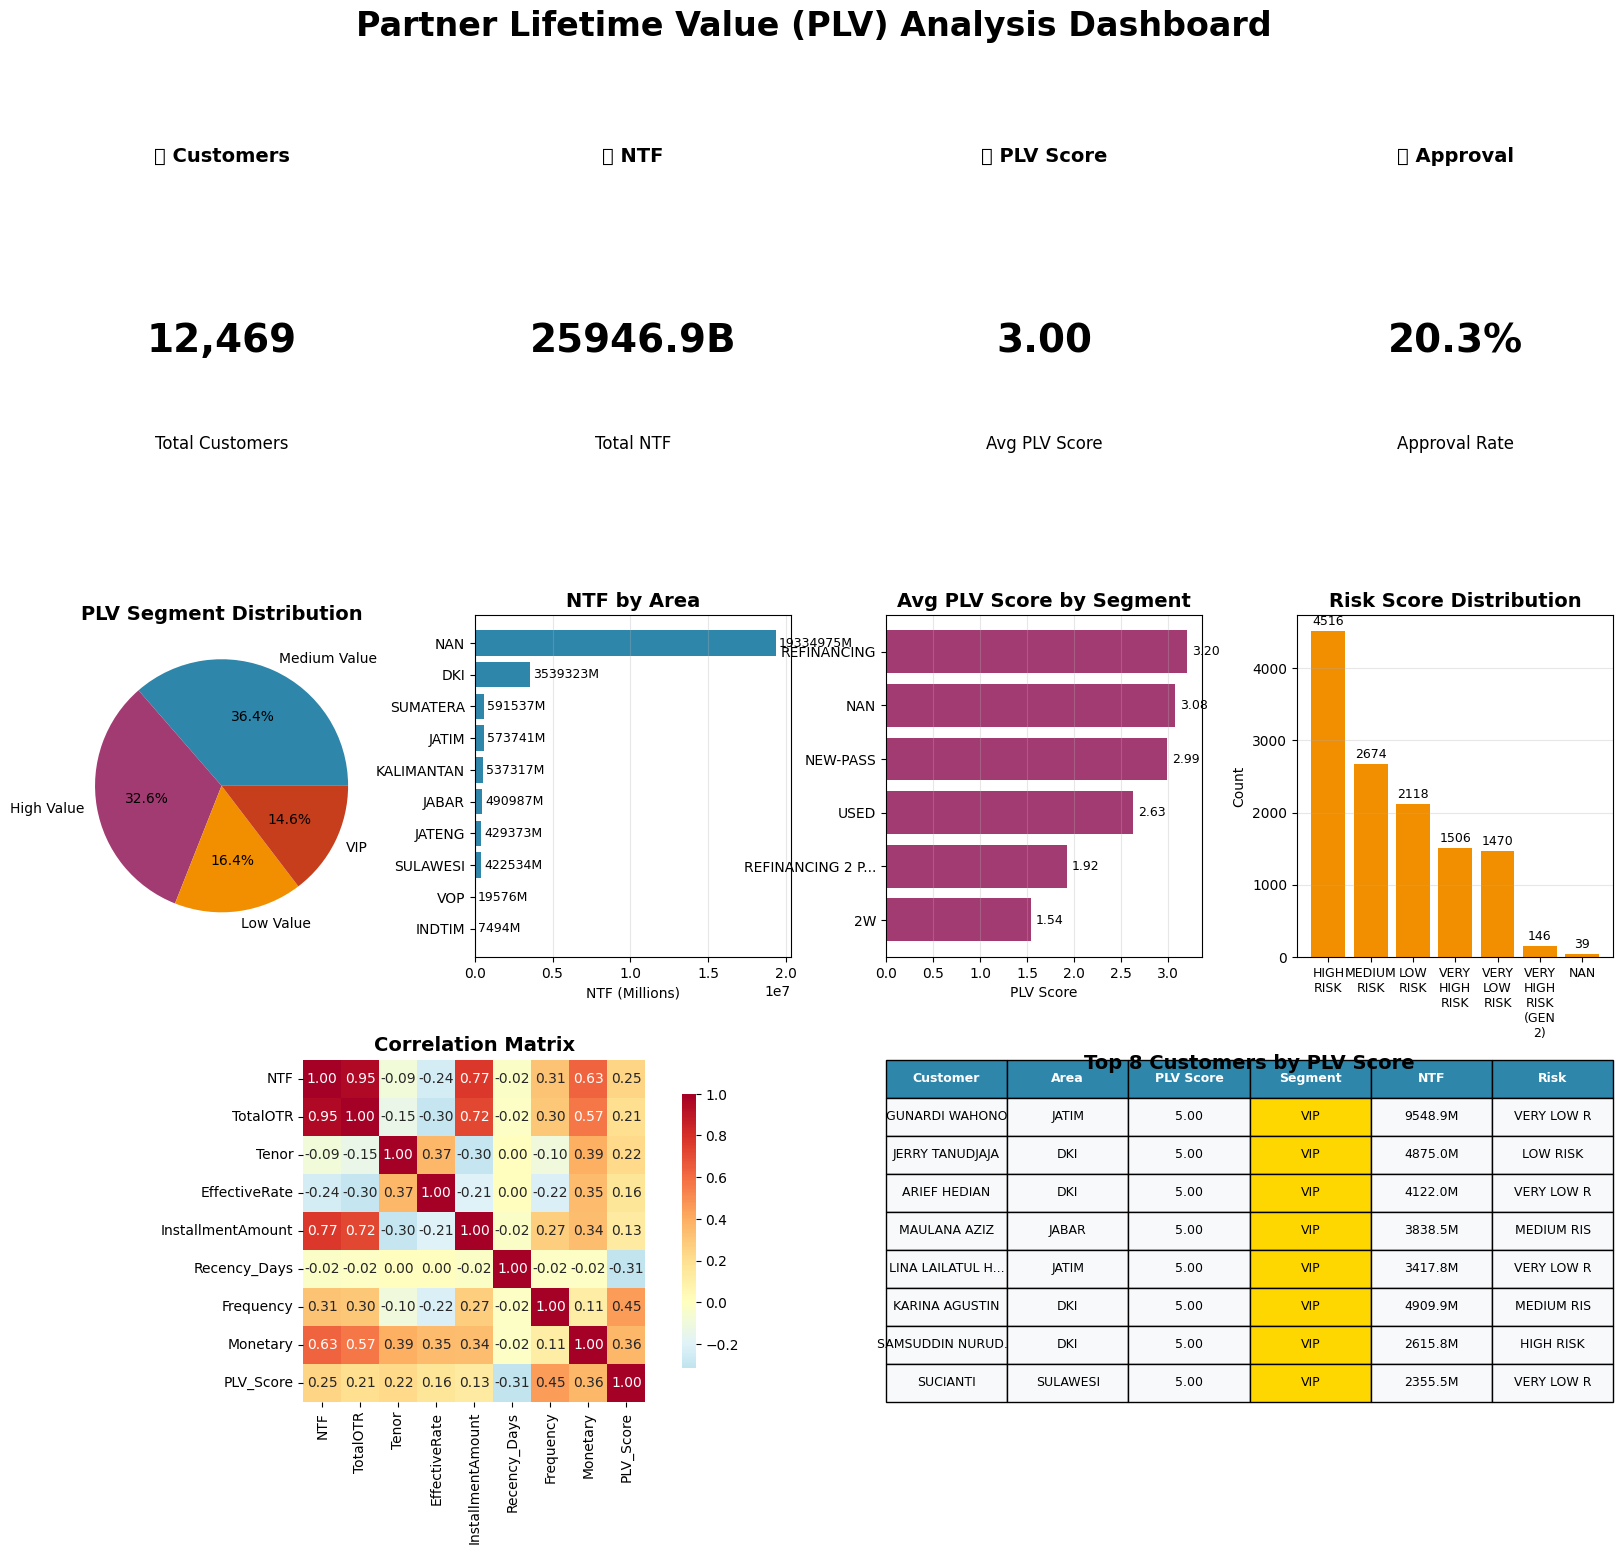

✅ Dashboard created successfully!

📊 DETAILED PLV ANALYSIS REPORT

1. OVERALL STATISTICS:
   • Total Customers: 12,469
   • Total NTF: Rp 25,946,858,676,090
   • Average NTF: Rp 2,080,909,349
   • Average PLV Score: 3.00
   • PLV Score Range: 1.00 - 5.00

2. PLV SEGMENT ANALYSIS:
              Count     Total_NTF      Avg_NTF  Avg_PLV  Share_%
PLV_Segment                                                     
Low Value      2042  3.526716e+06  1727.088970     1.64     16.4
Medium Value   4538  9.282580e+06  2045.522217     2.57     36.4
High Value     4066  8.168196e+06  2008.901995     3.52     32.6
VIP            1823  4.969368e+06  2725.928508     4.44     14.6

3. AREA PERFORMANCE:
            Customers   Total_NTF_M  Avg_PLV
AreaName                                    
INDTIM              2  7.493860e+03     3.30
NAN              9938  1.933498e+07     3.08
JATIM             173  5.737412e+05     2.97
KALIMANTAN        212  5.373168e+05     2.81
DKI              1222  3.539323e+06  

In [4]:
# ==========================================
# RUN THE ANALYSIS
# ==========================================

if __name__ == "__main__":
    # Run the main PLV analysis
    df_result = main()

    # You can also run individual functions:
    # df_result = quick_analysis('your_file.xlsx')
    # export_plv_segments(df_result)
    # compare_periods('file1.xlsx', 'file2.xlsx')

In [ ]:
# Run the main PLV analysis
df_result = main()